In [ ]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Optional

In [ ]:
points_list = list[tuple[float, float]]

def plot_path(
        points: points_list, 
        perm: list[int], 
        save_plot: bool = False,
        ax: plt.axes = plt, 
        title: str = ""
) -> Optional[Image]:
    """
        Plot salesman path given points and their permutation
    """
    xs = [points[perm[i]][0] for i in range(len(points))]
    ys = [points[perm[i]][1] for i in range(len(points))]
    
    xs.append(points[perm[0]][0])
    ys.append(points[perm[0]][1])
    ax.plot(xs, ys, marker='s', markerfacecolor='red')
    if ax != plt:
        ax.set_title(title)
    if save_plot:
        plt.ioff()
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='jpeg', bbox_inches="tight")
        plt.close()
        return Image.open(img_buf)
    elif ax == plt:
        ax.title(title)
        ax.show()


def plot_path_for_given_points(
        points: points_list, 
        ax: plt.axes = plt, 
        title: str =""
) -> None:
    """
        Plot salesman path with only given points
    """
    xs = [x1 for x1, _ in points] + [points[0][0]]
    ys = [y1 for _, y1 in points] + [points[0][1]]
    ax.plot(xs, ys, marker='s', markerfacecolor='red')
    if ax == plt:
        ax.title(title)
        ax.show()
    else:
        ax.set_title(title)


def plot_energy(energy: list[float], ax=plt) -> None:
    """
        Plot the objective function in successive iterations 
    """
    ax.plot([ind for ind in range(len(energy))], energy)
    if ax == plt:
        ax.title("Energy plot")
        ax.show()
    else:
        ax.set_title("Energy plot")

def plot_temperature(temperature: list[float], ax=plt) -> None:
    """
        Plot the temperature function in successive iterations 
    """
    ax.plot([ind for ind in range(len(temperature))], temperature)
    if ax == plt:
        ax.title("Temperature plot")
        ax.show()
    else:
        ax.set_title("Temperature plot")


In [23]:
from numpy.random import multivariate_normal as mvn

def generate_numbers(left: float, right: float, size: int) -> list[float]:
    return [np.random.uniform(left, right) for _ in range(size)]

def generate_uniform(size: int) -> points_list:
    return [(np.random.rand(), np.random.rand()) for _ in range(size)]

def euclid_dist(p1: tuple[float, float], p2: tuple[float, float]) -> float:
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def generate_clusters(cluster_size: int) -> points_list:
    cluster = []
    intervals = []
    for i in range(3):
        for j in range(3):
            intervals.append((i*10, i*10 + 2, j*10, j*10 + 2))

    for x1, y1, x2, y2 in intervals:
        cluster += [(w1, w2) for w1, w2 in zip(generate_numbers(x1, y1, cluster_size), generate_numbers(x2, y2, cluster_size))]
    return cluster


def generate_normal(size: int) -> points_list:
    sample1 = mvn([-5, -5], np.array([[1, 0], [0, 1]]), size = size)
    sample2 = mvn([5, 5], np.array([[1, 0], [0, 1]]), size = size)
    sample3 = mvn([-5, 5], np.array([[1, 0], [0, 1]]), size = size)
    sample4 = mvn([5, -5], np.array([[1, 0], [0, 1]]), size = size)
    return [(point[0], point[1]) for point in np.concatenate((sample1, sample2, sample3, sample4))]


3 variants of neighbor generating function:

1 - Consecutive swap = swapping the positions of two cities with indices a and a + 1. \
2 - Arbitrary swap = swapping the positions of two cities with indices a and b, where a and b are two arbitrary different indices. \
3 - Interval swap = reversing the order of cities in any interval <a, b>.

In [ ]:
def generate_neighbor1(perm: list[int]) -> list[int]:
    n = len(perm)
    x1 = np.random.randint(0, n - 1)
    new_p = perm[:]
    new_p[x1], new_p[x1 + 1] = new_p[x1 + 1], new_p[x1]
    return new_p


def generate_neighbor2(perm: list[int]) -> list[int]:
    n = len(perm)
    x1 = np.random.randint(0, n - 1)
    x2 = np.random.randint(x1 + 1, n)
    new_p = perm[:]
    new_p[x1], new_p[x2] = new_p[x2], new_p[x1]
    return new_p


def generate_neighbor3(perm: list[int]) -> list[int]:
    n = len(perm)
    x1 = np.random.randint(0, n - 1)
    x2 = np.random.randint(x1 + 1, n)
    new_p = perm[:]
    j = (x2 - x1) // 2
    for i in range(x1, x1 + j + 1):
        new_p[i], new_p[x2 + x1 - i] = new_p[x2 + x1 - i], new_p[i]
    return new_p

In [ ]:
def calculate_energy_for_permutation(dist_mat: list[list[float]], p: list[int]) -> float:
    energy = 0
    for i in range(1, len(p)):
        energy += dist_mat[p[i]][p[i-1]]
    energy += dist_mat[p[-1]][p[0]]
    return energy


A simple heuristic starting the path in a fixed city and at each step selecting the nearest city. The results can be compared with the path obtained after simulated annealing.

In [ ]:
def simple_salesman(points: points_list, ax=plt) -> None:
    n = len(points)
    path = [points[-1]]
    points.pop()
    last = points[0]
    for _ in range(n - 1):
        min_index = 0
        min_dist = euclid_dist(last, points[0])
        for i in range(1, len(points)):
            d = euclid_dist(last, points[i])
            if d < min_dist:
                min_dist = d
                min_index = i
        last = points.pop(min_index)
        path.append(last)

    path_length = 0
    for i in range(1, len(path)):
        path_length += euclid_dist(path[i], path[i-1])
    path_length += euclid_dist(path[-1], path[0])

    plot_path_for_given_points(path, ax=ax, title=f"Path length(heuristic): {np.round(path_length, 2)}")

Dynamic programming algorithm finding optimal solution( time complexity is $O(2^{n} \cdot n^{2}) $, so it will work for twenty cities at most

In [ ]:
def pop_count(number: int):
    count = 0
    while number:
        count += number % 2
        number //= 2
    return count


def to_bin(number: int):
    return to_bin(number // 2) + str(number%2) if number else ""

def optimal_salesman(points: points_list, ax=plt):
    n = len(points)
    matrix = [[euclid_dist(p1, p2) for p1 in points] for p2 in points]
    al = 1<<n
    dp = [[float("inf") for _ in range(n)] for _ in range(al)]
    parent = [[None for _ in range(n)] for _ in range(al)]
    dp[1][0] = 0
    for i in range(2, n + 1):
        for mask in range(al):
            if pop_count(mask) != i or not 1&mask:
                continue
            for city in range(1, n):
                bit_number = 1<<city
                if not bit_number & mask:
                    continue
                for last_city in range(n):
                    bit_number_last = 1<<last_city
                    if city == last_city or not bit_number_last&mask:
                        continue
                    if dp[mask][city] > dp[mask^bit_number][last_city] + matrix[city][last_city]:
                        dp[mask][city] = dp[mask^bit_number][last_city] + matrix[city][last_city]
                        parent[mask][city] = last_city

    ans = float("inf")
    cur_city = 0
    for city in range(1, n):
        if ans > dp[al - 1][city] + matrix[0][city]:
            ans = dp[al - 1][city] + matrix[0][city]
            cur_city = city

    ans_points = [points[cur_city]]
    mask = al - 1
    while cur_city:
        next_city = parent[mask][cur_city]
        ans_points.append(points[next_city])
        mask ^= 1<<cur_city
        cur_city = next_city

    plot_path_for_given_points(ans_points, ax=ax, title=f"Length of optimal route: {np.round(ans, 2)}")

#### Simulated Annealing Algorithm
The specific state is a permutation of cities. Neighbors are generated using one of the three methods mentioned earlier. The temperature function is an exponential function with a quotient alpha (typically around 0.95 - 0.99). In the main loop of the program, where temperatures are updated, there is another loop. It's there so that the algorithm can explore a larger neighborhood for a fixed temperature level (which usually results in better outcomes). The function calculating the probability of going to state with worse objective function value is $exp{\frac{-\Delta}{T}}$, where $\Delta$ is the change in energy when transitioning to the neighboring state, and $T$ is the temperature.

In [ ]:
def f(delta, T):
    return np.exp(-delta/T)

In [17]:
def annealing_salesman(
        points: points_list, 
        neighbor_fun: callable = generate_neighbor3, 
        steps: int =1000, 
        T0: int = 50, 
        alpha: float = 0.99, 
        no_of_iter: int = 40, 
        save_gif: bool = False, 
        ax: plt.axes = plt, 
        ax1=None, 
        ax2=None
) -> None:
    n = len(points)
    dist_matrix = [[euclid_dist(points[i], points[j]) for i in range(n)] for j in range(n)]
    p = [i for i in range(n)]
    cur_energy = calculate_energy_for_permutation(dist_matrix, p)
    energy_states = [cur_energy]
    T = T0
    temperature = [T0]

    for i in range(steps):
        for _ in range(no_of_iter):
            new_state = neighbor_fun(p)
            next_energy = calculate_energy_for_permutation(dist_matrix, new_state)
            if next_energy < cur_energy:
                p = new_state
                cur_energy = next_energy
            else:
                probability = f(next_energy - cur_energy, T)
                if probability > np.random.uniform(0, 1):
                    p = new_state
                    cur_energy = next_energy
        # if i % 20 == 0 and save_gif:
        #     frames.append(plot_path(points, p, save_plot=True))
        T *= alpha
        temperature.append(T)
        energy_states.append(cur_energy)


    plot_path(points, p, ax=ax, title=f"Path length(annealing): {np.round(calculate_energy_for_permutation(dist_matrix, p), 2)}")
    if ax1 is not None:
        plot_energy(energy_states, ax=ax1)
        plot_temperature(temperature, ax=ax2)

## Results

In [35]:
def shuffle(points: points_list) -> points_list:
    for _ in range(2*m):
        a = np.random.randint(0, m - 1)
        b = np.random.randint(a + 1, m)
        sample_points[a], sample_points[b] = sample_points[b], sample_points[a]
    return points

In [26]:
def draw4(points: points_list):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
    n = len(points)
    dist_matrix = [[euclid_dist(points[i], points[j]) for i in range(n)] for j in range(n)]
    plot_path_for_given_points(
        points[:], ax=ax1, 
        title=f"Initial random state: {np.round(calculate_energy_for_permutation(dist_matrix, [i for i in range(n)]), 2)}"
    )    
    simple_salesman(points[:], ax=ax2)
    optimal_salesman(points[:], ax=ax3)
    annealing_salesman(points[:], ax=ax4)


In [27]:
def draw_with_stats(points: points_list, **kwargs):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
    plot_path_for_given_points(sample_points[:], ax1)
    annealing_salesman(points[:], ax=ax2, ax1=ax3, ax2=ax4, **kwargs)

In [28]:
def draw_different_neighbors(points: points_list):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
    plot_path_for_given_points(points[:], ax=ax1)
    annealing_salesman(points[:], ax=ax2, neighbor_fun=generate_neighbor1, steps=3000, no_of_iter=80)
    annealing_salesman(points[:], ax=ax3, neighbor_fun=generate_neighbor2, steps=2000, no_of_iter=60)
    annealing_salesman(points[:], ax=ax4, neighbor_fun=generate_neighbor3)

#### Number of cities=20, uniform distribution

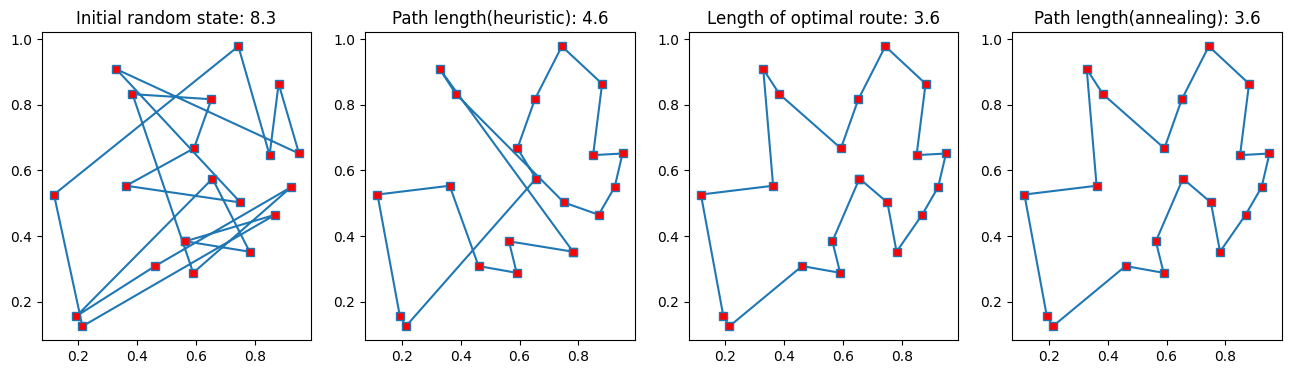

In [29]:
m = 20
sample_points = shuffle(generate_uniform(m))
draw4(sample_points)

#### Number of cities = 20, Normal distribution in 4 unique clusters

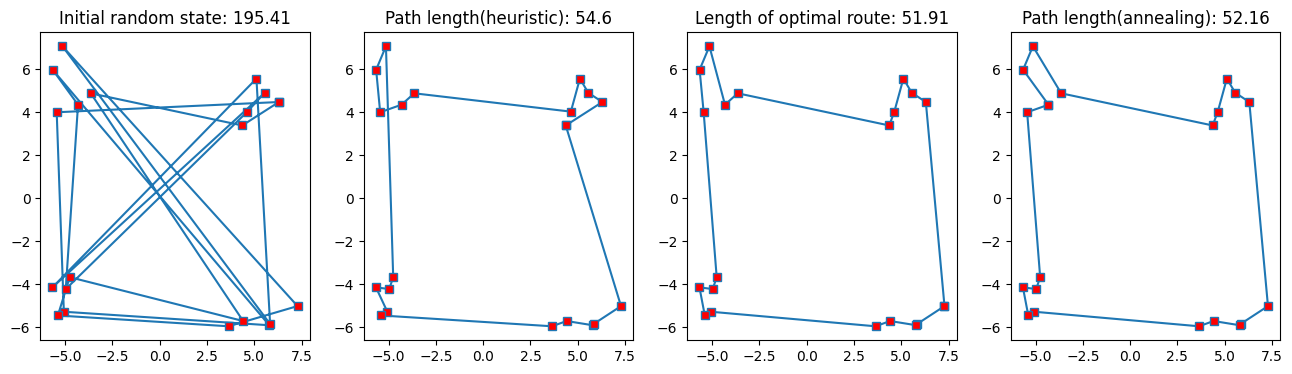

In [30]:
m = 20
sample_points = shuffle(generate_normal(m // 4))
draw4(sample_points)

#### Number of cities = 90, 9 clusters

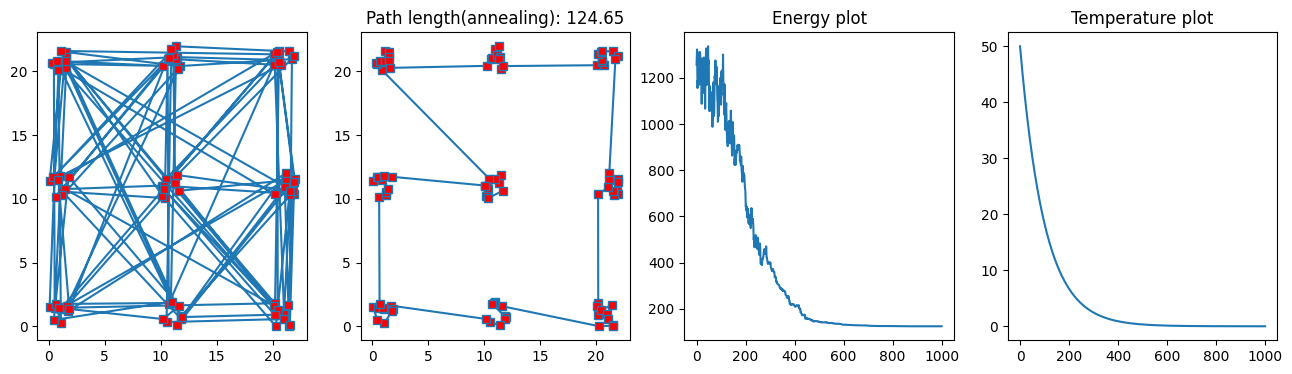

In [31]:
m = 90
sample_points = shuffle(generate_clusters(m // 9))
draw_with_stats(sample_points)

#### Number of cities = 200, Uniform distribution

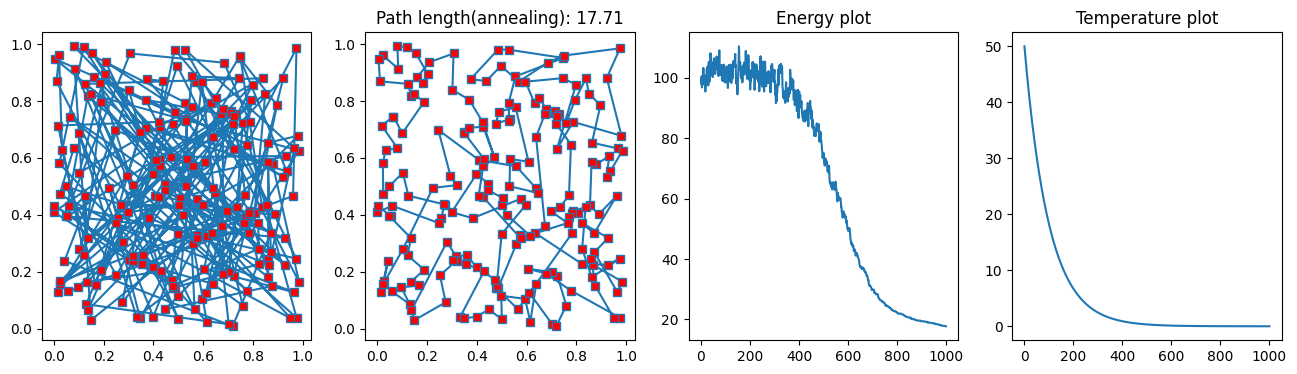

In [32]:
m = 200
sample_points = shuffle(generate_uniform(m))
draw_with_stats(sample_points)

#### Number of cities = 100, Normal distribution

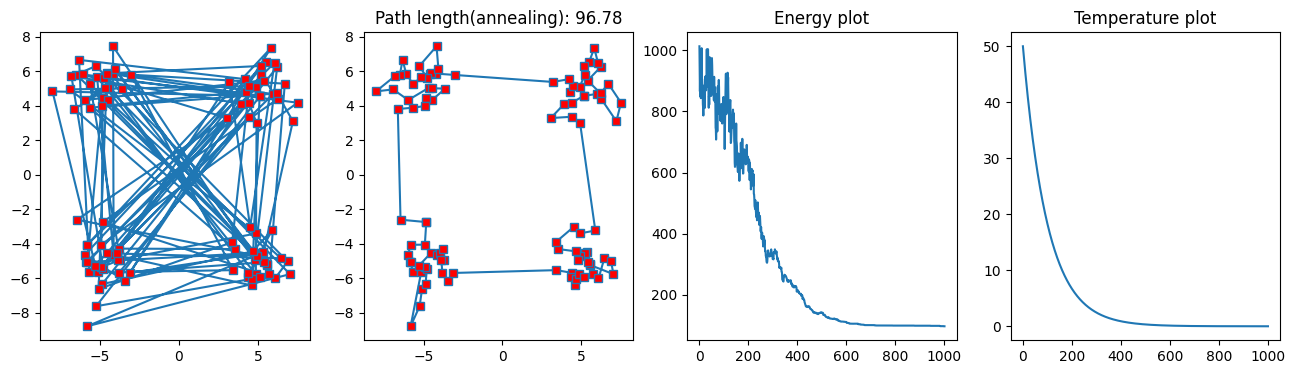

In [33]:
m = 100
sample_points = shuffle(generate_normal(m // 4))
draw_with_stats(sample_points)

## Comparison of different neighbor generating functions

#### Comparison for points from normal distribution
The plots depict, respectively: the initial state, the final state using consecutive swap, the final state using arbitrary swap, and the final state using the interval swap function. In earlier plots for simulated annealing, the interval swap function was used.

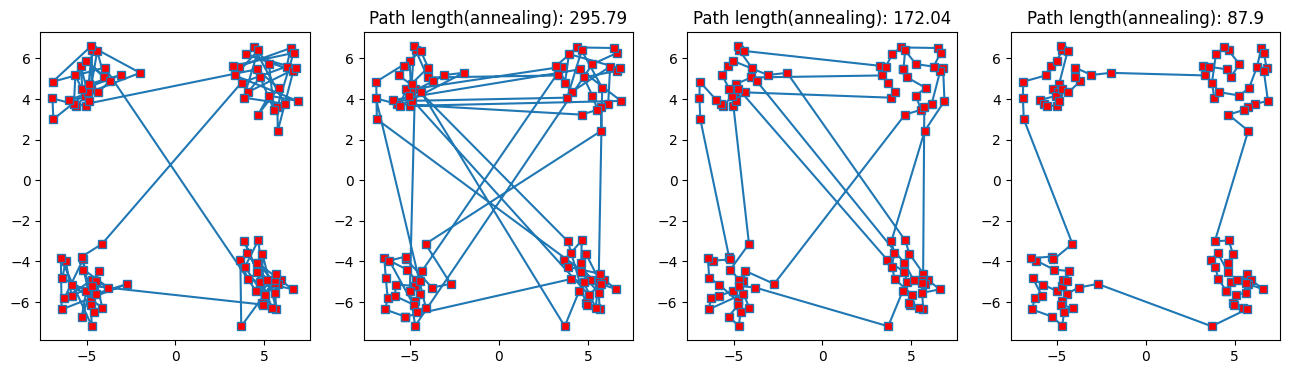

In [36]:
m = 100
sample_points = shuffle(generate_normal(m // 4))
draw_different_neighbors(sample_points)

#### Plots only for consecutive swap

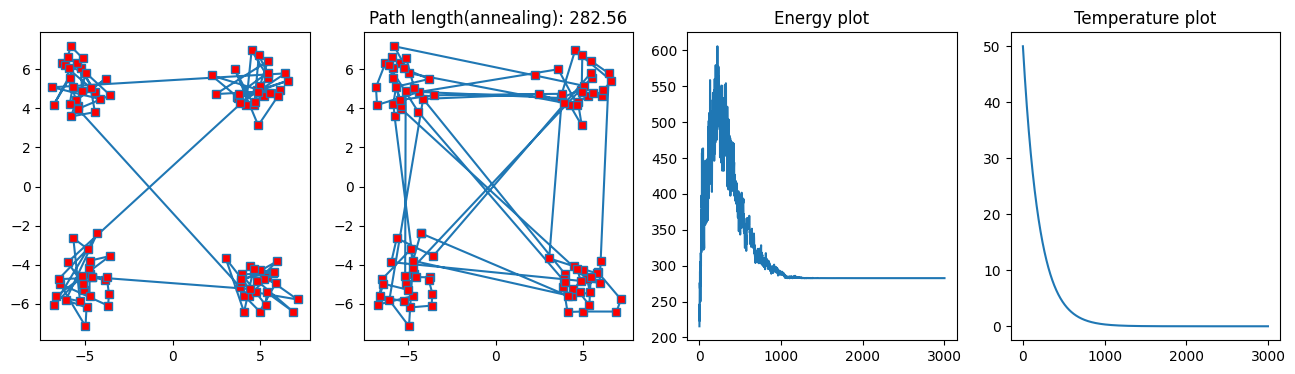

In [37]:
m = 100
sample_points = shuffle(generate_normal(m // 4))
draw_with_stats(sample_points, neighbor_fun=generate_neighbor1, steps=3000, no_of_iter=80, alpha=0.995)

#### Plots only for arbitrary swap

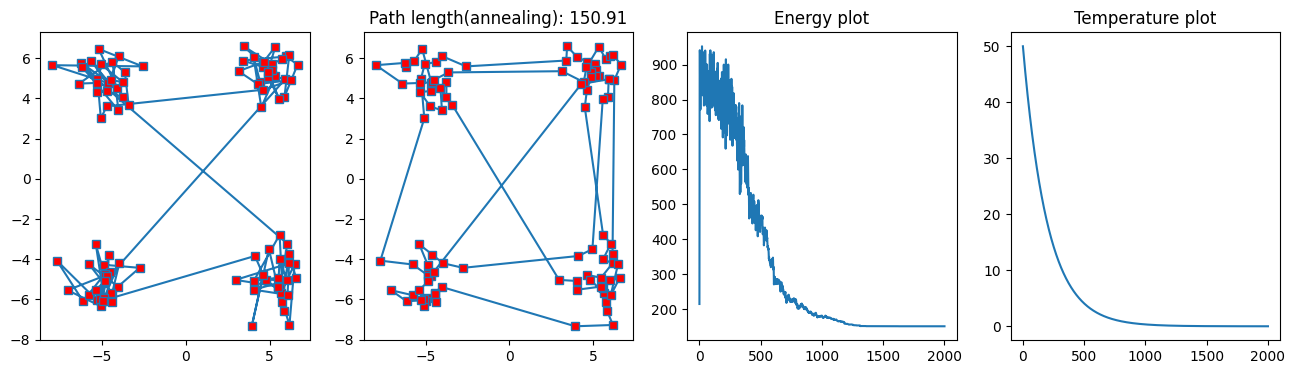

In [38]:
m = 100
sample_points = shuffle(generate_normal(m // 4))
draw_with_stats(sample_points, neighbor_fun=generate_neighbor2, steps=2000, no_of_iter=60, alpha=0.995)

#### Plots only for interval swap

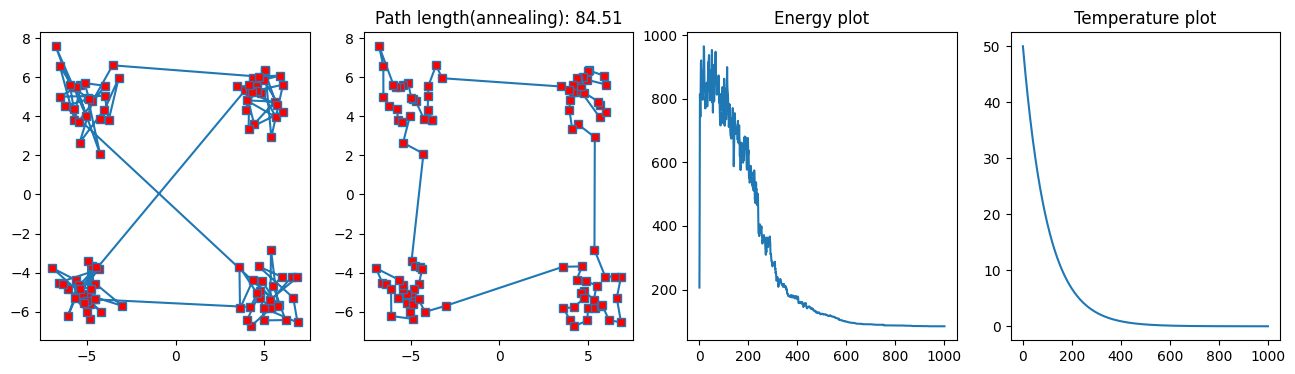

In [39]:
m = 100
sample_points = shuffle(generate_normal(m // 4))
draw_with_stats(sample_points, neighbor_fun=generate_neighbor3)

#### Comparison of functions for uniform distribution

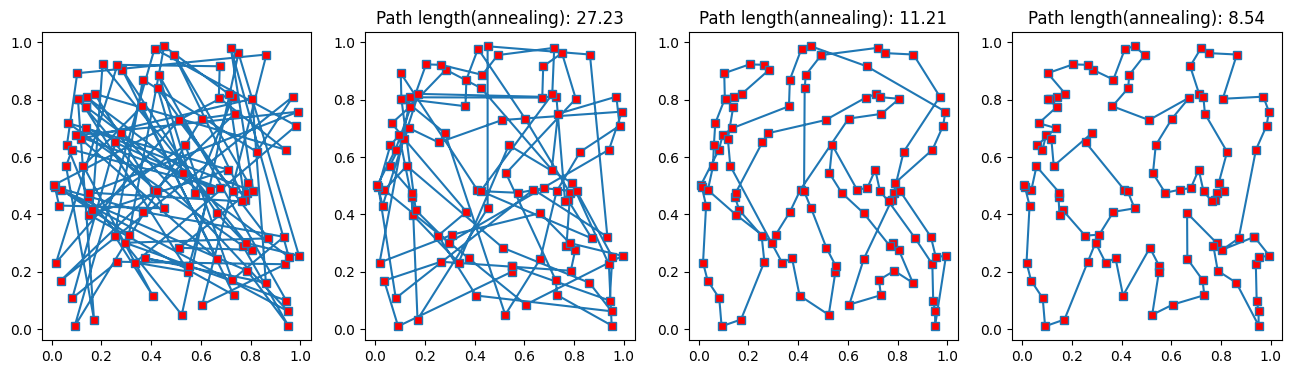

In [40]:
m = 100
sample_points = shuffle(generate_uniform(m))
draw_different_neighbors(sample_points)

#### Plots only for consecutive swap

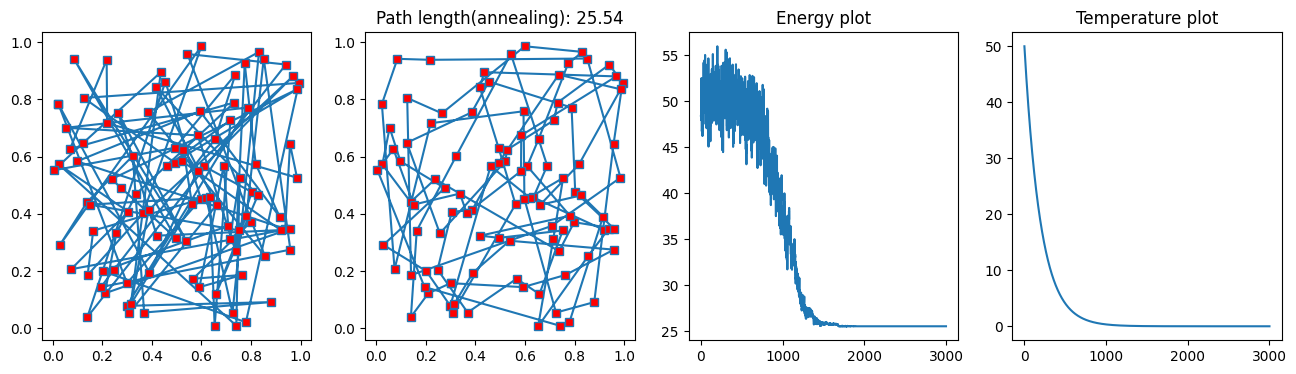

In [41]:
m = 100
sample_points = shuffle(generate_uniform(m))
draw_with_stats(sample_points, neighbor_fun=generate_neighbor1, steps=3000, no_of_iter=80, alpha=0.995)

#### Plots only for arbitrary swap

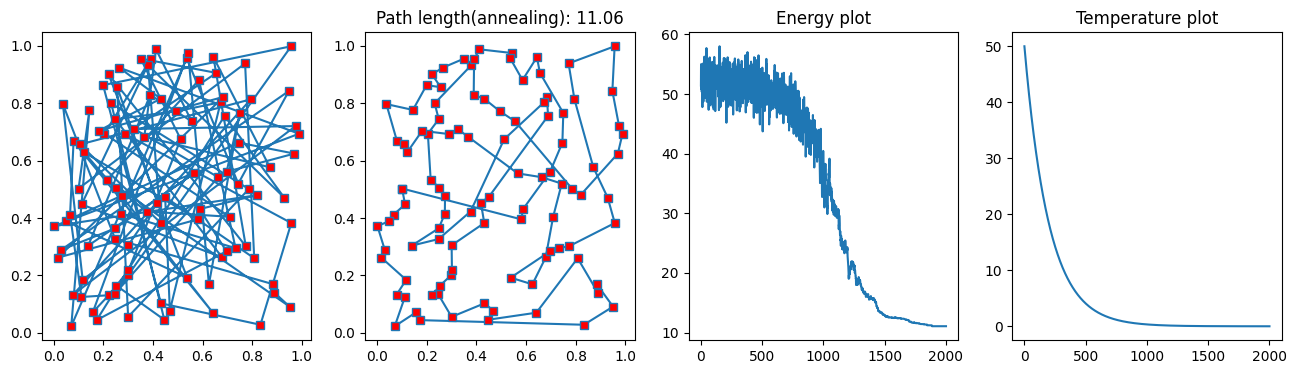

In [42]:
m = 100
sample_points = shuffle(generate_uniform(m))
draw_with_stats(sample_points, neighbor_fun=generate_neighbor2, steps=2000, no_of_iter=60, alpha=0.995)

#### Plots only for interval swap

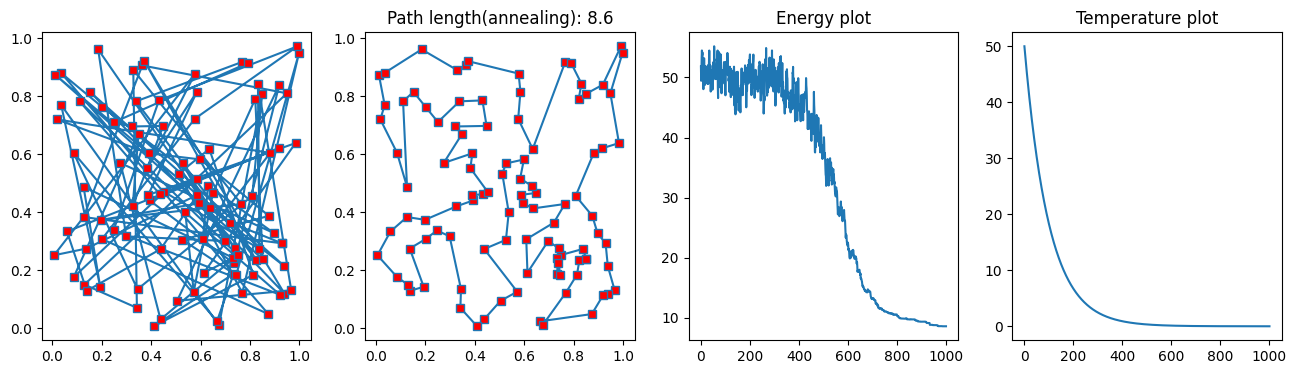

In [43]:
m = 100
sample_points = shuffle(generate_uniform(m))
draw_with_stats(sample_points, neighbor_fun=generate_neighbor3)

#### Conclusions
In practically every case, the best function was the one that reversed the order of cities over an entire interval. The other two produced much worse results. Typically, the algorithm that always chose the nearest city found better results. The performance of these functions did not improve significantly with various parameter settings. Changing the temperature function from exponential to 
 $\frac{1}{x}$ only worsened the final results.

## Visualisation of annealing process

#### Normal distribution, 100 cities

<img src="annealing_gifs/normal.gif" width="500" align="center">

#### Uniform distribution, 100 cities

<img src="annealing_gifs/uniform.gif" width="500" align="center">